# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Objectibe

My Objective in this project is to analyze the data provided and then by using machine learning predict whether or not customer will respond to an offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import re
import sys
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Processing


## Protfolio Data Processing

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
# Rename id column name to offer_id
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [5]:
# Seperate Cahnnels 
web = []
email = []
mobile = []
social = []
for i in portfolio.itertuples():
    if 'web' in i.channels:
        web.append(1)
    else:
        web.append(0)
    if 'email' in i.channels:
        email.append(1)
    else:
        email.append(0)
    if  'mobile' in i.channels:
        mobile.append(1)
    else:
        mobile.append(0)
    if 'social' in i.channels:
        social.append(1)
    else:
        social.append(0)
portfolio['web'] = web
portfolio['email'] = email
portfolio['mobile'] = mobile
portfolio['social'] = social
    
portfolio.drop(['channels'], axis=1, inplace=True)

In [6]:
# dummies for offer type
dummies = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio,dummies],axis=1)
portfolio.drop(['offer_type'], axis=1, inplace=True)

In [7]:
# duration from days to hours
    
duration = []
for i in portfolio['duration']:
    duration_in_hours = i * 24 
    duration.append(duration_in_hours)
    
portfolio['duration'] = duration

In [8]:
portfolio.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


## Profile Data Processing

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
# Rename id colmun name to customer_id.
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [11]:
# Check nan values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

In [12]:
# Change the date format for became_member_on column
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

In [13]:
# Create start year column for further investigations
profile['start_year'] = profile.became_member_on.dt.year

In [14]:
# Fix gender ,2175 rows putting NA
profile['gender'] = profile['gender'].fillna('NA')

In [15]:
#fill income with mean
profile['income'] = profile['income'].fillna(profile['income'].mean())
#rounding
profile.round({'income':0})

,age,became_member_on,gender,customer_id,income,start_year
0,118,2017-02-12,NA,68be06ca386d4c31939f3a4f0e3dd783,65405.0,2017
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
2,118,2018-07-12,NA,38fe809add3b4fcf9315a9694bb96ff5,65405.0,2018
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
4,118,2017-08-04,NA,a03223e636434f42ac4c3df47e8bac43,65405.0,2017
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
6,118,2017-09-25,NA,8ec6ce2a7e7949b1bf142def7d0e0586,65405.0,2017
7,118,2017-10-02,NA,68617ca6246f4fbc85e91a2a49552598,65405.0,2017
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
9,118,2016-11-22,NA,8974fc5686fe429db53ddde067b88302,65405.0,2016


In [16]:
# investagte rows with age 118
profile.loc[profile['age']==118].head()

,age,became_member_on,gender,customer_id,income,start_year
0,118,2017-02-12,NA,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017
2,118,2018-07-12,NA,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018
4,118,2017-08-04,NA,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017
6,118,2017-09-25,NA,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568,2017
7,118,2017-10-02,NA,68617ca6246f4fbc85e91a2a49552598,65404.991568,2017


In [17]:
# so anyone with age 118 has unknown gender and also an income NaN value,
# I decided to drop all those rows that contains 118 in age
profile.drop(profile.loc[profile['age']==118].index, inplace=True)

In [18]:
profile.head()

,age,became_member_on,gender,customer_id,income,start_year
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


## Transcript Data Processing

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
# Rename person column name to customer_id
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [21]:
# Check for nan values
transcript.isna().sum()

event          0
customer_id    0
time           0
value          0
dtype: int64

In [22]:
# Check unique events 
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [23]:
# Fixing the value columns
# Listing all the the types
types = []
for i,j in transcript.iterrows():
    for k in j['value']:
        if k in types:
            continue
        else:
            types.append(k)

types

['offer id', 'amount', 'offer_id', 'reward']

In [24]:
# List each type in seperated column
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for i, j in transcript.iterrows():
    for k in j['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[i, 'offer_id']= j['value'][k]
        if k == 'amount':
            transcript.at[i, 'amount']= j['value'][k]
        if k == 'reward':
            transcript.at[i, 'reward']= j['value'][k]

In [25]:
transcript = transcript.drop('value', axis=1)

In [26]:
transcript.head()

,event,customer_id,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [27]:
transcript.shape

(306534, 6)

In [28]:
# Drop transaction rows where customer_id is not in customer_id in profile dataset
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [29]:
transcript.shape

(272762, 6)

33772 rows dropped in transcript dataset because their customer id is not in the profile dataset

In [30]:
# investigate duplicate values
transcript.duplicated().sum()

374

In [31]:
# Drop duplicated values then reset the index
transcript.drop_duplicates(inplace=True)
transcript.reset_index(drop=True, inplace=True)

In [32]:
transcript.shape

(272388, 6)

In [33]:
# Extract transactions from transcript data and make it in its own dataframe
transactions = transcript[transcript.event=='transaction'].copy()
transactions.drop(columns=['offer_id', 'event'], inplace=True)
transactions.head()

,customer_id,time,amount,reward
11027,02c083884c7d45b39cc68e1314fec56c,0,0,0
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34,0
11032,54890f68699049c2a04d415abc25e717,0,13,0
11040,b2f1cd155b864803ad8334cdf13c4bd2,0,19,0
11041,fe97aa22dd3e48c8b143116a8403dd52,0,18,0


In [34]:
# Extract offers from transcript data
offers = transcript[transcript.event!='transaction'].copy()

In [35]:
# one-hot encoding for offer events
offers['received'] = offers.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers['completed'] = offers.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers['viewed'] = offers.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

In [36]:
offers.drop(columns=['event', 'amount'], inplace=True)

In [37]:
offers.head()

,customer_id,time,offer_id,reward,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0


Now the data is clean and ready for analysis 

# Data Exploration and Analysis

What is the average income for Starbucks customers?

In [38]:
profile['income'].mean()

65404.9915682968

What are the top 5 incomes for Starbucks customers?

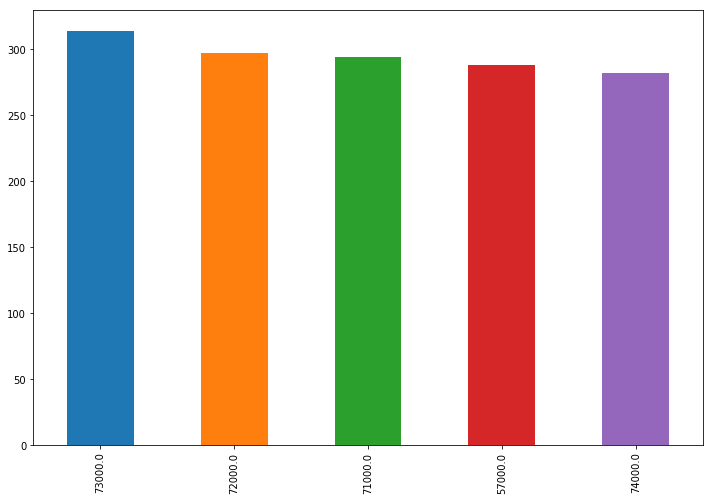

In [39]:
top_income = profile['income'].value_counts().head(5)
top_income
# Plot age with most gold medals
plt.figure(figsize=(12,8))
top_income.plot(kind="bar")

What is the average age for Starbucks customers?

In [40]:
profile['age'].mean()

54.39352445193929

What are the top 5 ages for Starbucks customers?

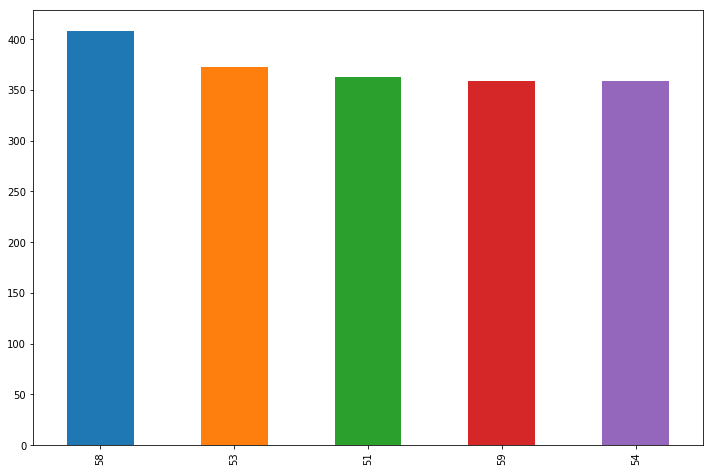

In [41]:
top_ages = profile['age'].value_counts().head(5)

# Plot
plt.figure(figsize=(12,8))
top_ages.plot(kind="bar")

How many members per year join Starbucks?

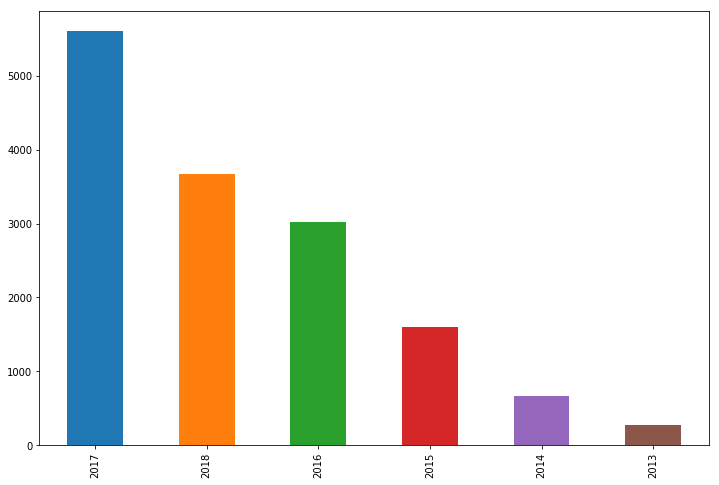

In [42]:
year_count = profile['start_year'].value_counts()

# Plot 
plt.figure(figsize=(12,8))
year_count.plot(kind="bar")

What is the most common promotion?

In [43]:
completed_offers_count = offers[offers['completed'] == 1]
most_promotion = completed_offers_count["offer_id"].value_counts().head(1)
most_promotion

fafdcd668e3743c1bb461111dcafc2a4    4957
Name: offer_id, dtype: int64

What are the top 5 common promotions?

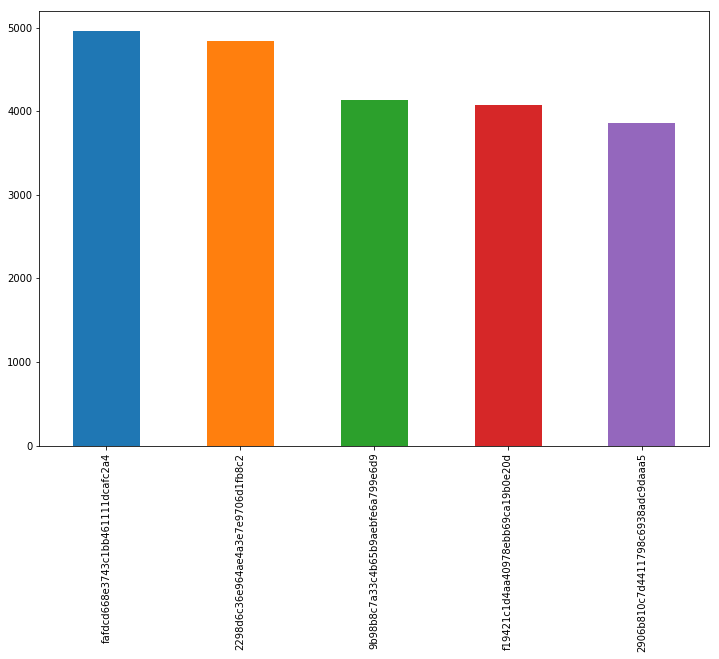

In [44]:
completed_offers_count = offers[offers['completed'] == 1]
cc = completed_offers_count["offer_id"].value_counts().head(5)
# Plot age with most gold medals
plt.figure(figsize=(12,8))
cc.plot(kind="bar")

What is the least common promotion?

In [45]:
least_promotion = completed_offers_count["offer_id"].value_counts().tail(1)
least_promotion

4d5c57ea9a6940dd891ad53e9dbe8da0    3281
Name: offer_id, dtype: int64

What are the most events we have in our transcripts?

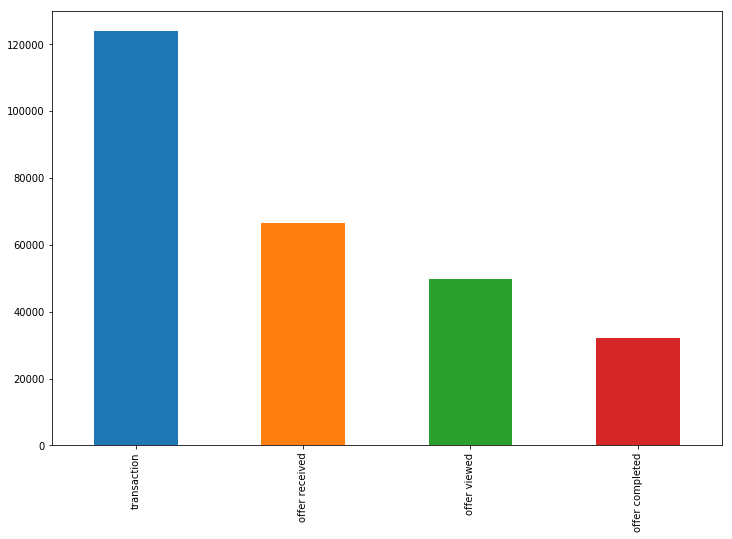

In [46]:
plt.figure(figsize=(12,8))
transcript['event'].value_counts().plot(kind="bar")

# Build a Model

In [ ]:
# build a model to predict whether or not customer will respond to an offer

First I need to combine all portfolio, profile, offers and transaction datasets to one dataset


In [47]:
def combine_data(profile, portfolio, offers, transaction):
    data = []
    customer_ids = offers['customer_id'].unique()
    
    # loop through all customer ids in offers dataframe
    for i in range(len(customer_ids)):
        
        # get customer id 
        cust_id = customer_ids[i]
        
        # get customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # get offers listed with the customer from offers_df
        customer_offers_data = offers[offers['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        customer_transaction_data = transaction[transaction['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = customer_offers_data[customer_offers_data['received'] == 1]
        offer_viewed_data = customer_offers_data[customer_offers_data['viewed'] == 1]
        offer_completed_data = customer_offers_data[customer_offers_data['completed'] == 1]
        
        
        data_rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # get an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # get offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # get duration days of an offer
            duration_days = offer_row['duration'].values[0]
            
            # start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # offers completed within end date
            offer_completed_withintime = np.logical_and(offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # offers viewed within end date
            off_viewed_withintime = np.logical_and(offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = offer_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # get transactions occured within time
            transaction_withintime = np.logical_and(customer_transaction_data['time'] >= start_time, customer_transaction_data['time'] <= end_time)
            transaction_data = customer_transaction_data[transaction_withintime]
            
            # amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            data_rows.append(row)
        
        data.extend(data_rows)
    
    data = pd.DataFrame(data)
    return data

In [48]:
# Combnining the data together
data = combine_data(profile, portfolio, offers, transactions)

In [49]:
data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

In [50]:
# data to csv
data.to_csv('clean_data.csv', index=False)

In [51]:
# Read from csv
data = pd.read_csv('clean_data.csv')

In [52]:
column_ordering = ['offer_id', 'offer_successful']
column_ordering.extend([elem for elem in data.columns if elem not in column_ordering])
data = data[column_ordering]

In [53]:
# Droping the columns that not needed in our model 
data = data.drop(columns=['customer_id', 'became_member_on', 'informational'])
data.head()

,offer_id,offer_successful,age,bogo,difficulty,discount,duration,email,gender,income,mobile,reward,social,start_year,time,total_amount,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,75,1,5,0,168,1,F,100000.0,1,5,0,2017,0,36,1
1,5a8bc65990b245e5a138643cd4eb9837,0,75,0,0,0,72,1,F,100000.0,1,0,1,2017,168,48,0
2,ae264e3637204a6fb9bb56bc8210ddfd,1,75,1,10,0,168,1,F,100000.0,1,10,1,2017,408,47,0
3,f19421c1d4aa40978ebb69ca19b0e20d,1,75,1,5,0,120,1,F,100000.0,1,5,1,2017,504,47,1
4,2906b810c7d4411798c6938adc9daaa5,0,68,0,10,1,168,1,M,70000.0,1,2,0,2018,0,0,1


In [54]:
# gender get_dummies
data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [55]:
# offer_id dummy labels
offer_id_labels = data['offer_id'].astype('category').cat.categories.tolist()
replace_offer_id = {'offer_id' : {k: v for k,v in zip(offer_id_labels,list(range(1,len(offer_id_labels)+1)))}}
print(replace_offer_id)

{'offer_id': {'0b1e1539f2cc45b7b9fa7c272da2e1d7': 1, '2298d6c36e964ae4a3e7e9706d1fb8c2': 2, '2906b810c7d4411798c6938adc9daaa5': 3, '3f207df678b143eea3cee63160fa8bed': 4, '4d5c57ea9a6940dd891ad53e9dbe8da0': 5, '5a8bc65990b245e5a138643cd4eb9837': 6, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 7, 'ae264e3637204a6fb9bb56bc8210ddfd': 8, 'f19421c1d4aa40978ebb69ca19b0e20d': 9, 'fafdcd668e3743c1bb461111dcafc2a4': 10}}


In [56]:
data.replace(replace_offer_id, inplace=True)

In [57]:
data.offer_id.unique()

array([ 7,  6,  8,  9,  3,  4, 10,  2,  1,  5])

In [58]:
data.dtypes

offer_id              int64
offer_successful      int64
age                   int64
bogo                  int64
difficulty            int64
discount              int64
duration              int64
email                 int64
gender                int64
income              float64
mobile                int64
reward                int64
social                int64
start_year            int64
time                  int64
total_amount          int64
web                   int64
dtype: object

In [59]:
data.head()

,offer_id,offer_successful,age,bogo,difficulty,discount,duration,email,gender,income,mobile,reward,social,start_year,time,total_amount,web
0,7,1,75,1,5,0,168,1,0,100000.0,1,5,0,2017,0,36,1
1,6,0,75,0,0,0,72,1,0,100000.0,1,0,1,2017,168,48,0
2,8,1,75,1,10,0,168,1,0,100000.0,1,10,1,2017,408,47,0
3,9,1,75,1,5,0,120,1,0,100000.0,1,5,1,2017,504,47,1
4,3,0,68,0,10,1,168,1,1,70000.0,1,2,0,2018,0,0,1


The target variable is offer_successful, and features are the rest.

In [60]:
# factors/features that influence the label variable
features = data.drop(columns=['offer_successful'])

# label variable to predict
label = data.filter(['offer_successful'])

In [61]:
# Normalize
scaler = MinMaxScaler()
to_normalize = ['time', 'total_amount', 'reward', 'age', 'duration', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,offer_id,age,bogo,difficulty,discount,duration,email,gender,income,mobile,reward,social,start_year,time,total_amount,web
0,7,0.686747,1,5,0,0.571429,1,0,0.777778,1,0.5,0,2017,0.000000,0.030050,1
1,6,0.686747,0,0,0,0.000000,1,0,0.777778,1,0.0,1,2017,0.291667,0.040067,0
2,8,0.686747,1,10,0,0.571429,1,0,0.777778,1,1.0,1,2017,0.708333,0.039232,0
3,9,0.686747,1,5,0,0.285714,1,0,0.777778,1,0.5,1,2017,0.875000,0.039232,1
4,3,0.602410,0,10,1,0.571429,1,1,0.444444,1,0.2,0,2018,0.000000,0.000000,1


After I successfully combined the datasets its time to build the model

In [62]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.3, random_state=42)

In [63]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (46550, 16)
Training Labels Shape: (46550, 1)
Testing Features Shape: (19951, 16)
Testing Labels Shape: (19951, 1)


### Random Forest

In [65]:
scorer = make_scorer(fbeta_score, beta=0.5)

# Random forest classifier object
rf = RandomForestClassifier(random_state=42)
# Fit the model
rf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [66]:
# Evaluate the model performance
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

In [68]:
evaluate_model_performance(rf, X_test, y_test)

RandomForestClassifier model accuracy: 0.901
RandomForestClassifier model f1-score: 0.895


(0.9012079595007769, 0.8953321650469971)

### Model Improvements

In [69]:
scorer = make_scorer(fbeta_score, beta=0.5)

# Random forest classifier object
rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples
min_samples_split = [2, 5, 10]

# Minimum number of samples leafs
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# The classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 3)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   25.8s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  4.8min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=3,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [70]:
# #valuate Random forrest
evaluate_model_performance(rf_random.best_estimator_, X_test, y_test)

RandomForestClassifier model accuracy: 0.913
RandomForestClassifier model f1-score: 0.910


(0.9133878001102702, 0.9101590932723302)

After using Grid Params results improve slightly









# Conclusion

In this project I analyzed the Starbucks app mobile rewards, and built a model to predict whether or no a customer will respond to and offer, the target variable is offer_successul and the idea behind this variable is I calculate if the offer is received and viewed and completed is going to be a successful offer the model was using random Forrest model, and I tried to improve it by using grid search, and I got 1 91% of accuracy and F1 score.

# Improvments

I think I did a good start in this project,
maybe a little improvement needed to obtain to the optimum solution, like using another machine learning models, or in the data preparation part and find more relations in the datasets.